In [ ]:
# Essentials
import numpy as np
import numpy.linalg as lg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import re #########

# Tensor
import tensorflow as tf
import tensorflow_hub as hub

# NLTK
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk import pos_tag
nltk.download("stopwords")
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [ ]:
embedder = hub.load(module_url)



In [ ]:
def TextPreprocesor(sentence):

  text = sentence.lower()
  text_p = "".join([char for char in text if char not in string.punctuation])
  clean_sentence = re.sub(r'http\S+', '', text_p)
  return clean_sentence
        

In [ ]:
def embed(sentence):
  sentence_in = [sentence]
  return embedder(sentence_in)

In [66]:
def data_Load(file):
  data = pd.read_csv(file, header = 0,encoding= 'iso-8859-1')
  X = data.Tweet
  return X


In [68]:
X=data_Load('/content/data_elonmusk.csv')

In [76]:
def LoadVectors(X):
  Dict_of_sent = dict() #or use {} intead
  for i in range(len(X)):  
    Dict_of_sent[i] = {"sentence":X[i],"vector": embed(TextPreprocesor(X[i]))}
  return Dict_of_sent


In [77]:
MyNLP_dictionary = LoadVectors(X)

In [83]:
MyNLP_dictionary[1]['sentence']

'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?'

In [112]:
my_tweets =[]

In [113]:
for i in range(len(X)):
  my_tweets.append(np.hstack(MyNLP_dictionary[i]["vector"].numpy()))
my_tweets = np.vstack(my_tweets)

In [114]:
my_tweets

array([[-0.00965876, -0.04810885, -0.01978337, ...,  0.0475996 ,
        -0.01902038,  0.02726135],
       [ 0.01734015, -0.06106213, -0.06993027, ...,  0.02043619,
        -0.01934779, -0.01334572],
       [ 0.04200516, -0.02571639,  0.00646962, ..., -0.04399165,
         0.00909323, -0.05910819],
       ...,
       [-0.03936957, -0.05778862,  0.00208145, ...,  0.04549709,
        -0.04390396, -0.08201448],
       [ 0.01513504, -0.03059488,  0.00839877, ...,  0.01190012,
        -0.0149893 , -0.0121182 ],
       [ 0.008053  , -0.02514688,  0.00782774, ...,  0.02444937,
         0.04813436, -0.04135374]], dtype=float32)

## Implementing K-Means Clustering

In [84]:
def Responsibility(X,means,beta=1e-3,*args,**kwargs):
  diff=[]
  responsibilities=[]

  for mean in means:
    diff =X -mean
    dist =(np.sum(diff ** 2,axis=1,keepdims=True))

    numerator= np.exp(-beta*dist)
    denominator=np.sum(numerator)
    responsability=-numerator/denominator

    responsibilities.append(responsability)
  return np.hstack(responsibilities)

In [87]:
def Distance(x, means, *args,**kwargs):
  diff=[]
  dists=[]
  for mean in means:
    diff=x-mean
    ##dist=np.sqrt(np.sum(diff**2,axis=1,keepdims=True))
    dist=(np.sum(diff**2,axis=1,keepdims=True))
    dists.append(dist)
  return np.hstack(dists)
  


In [94]:
class K_Means:
  def __init__(self, k=3, distance_func=Distance, beta=None):
    self.k=k
    self.distance_func=distance_func
    self.beta=beta

  def Fit(self,X,iterations=5):
    indices = np.arange(X.shape[0])
    sample_indices = np.random.choice(indices,size=self.k,replace=False)
    self.means = X[sample_indices]

    for i in range(iterations):
      y_hat = self.Predict(X)
      self.means=[]
      for j in range(self.k):
        mean=np.mean(X[y_hat==j], axis=0)
        self.means.append(mean)
      self.means=np.vstack(self.means)

    y_hat=self.Predict(X)
    plt.figure(figsize=(10,7))
    plt.scatter(X[:,0],X[:,1],s=1,c=y_hat)
    plt.scatter(self.means[:,0],self.means[:,1], c='k',s=10)

    return y_hat
  
  def Predict(self,X):
    dist=self.distance_func(X,self.means,self.beta)
    y_hat = np.argmin(dist,axis=1)
    return y_hat


In [95]:
elonizer2000 = K_Means(k=6)

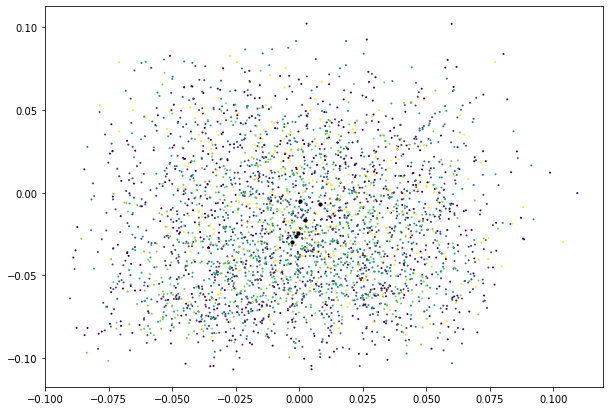

In [99]:
elonizer2000.Fit(my_tweets2)

In [103]:
y_hat[2]

4

TypeError: ignored

In [118]:
elonizer2000_soft = K_Means(k=12, distance_func=Responsibility,beta=1.6)

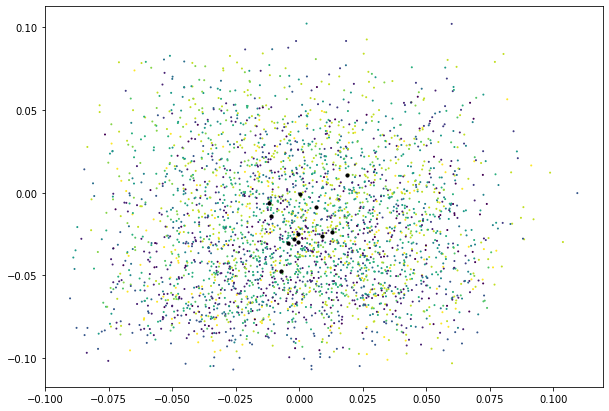

In [119]:
y_hat2=elonizer2000_soft.Fit(my_tweets,iterations=8)

In [120]:
for i in range(200,400):
  print(y_hat2[i],"  ",MyNLP_dictionary[i]['sentence'])

10    @iFahadUddin @EricDiepeveen Maybe not medically tho. Dunno. Bad feelings correlate to bad events, so maybe real pro? https://t.co/Eh26YGUZdO
10    @iFahadUddin @EricDiepeveen Yeah
3    @EricDiepeveen The reality is great highs, terrible lows and unrelenting stress. Don't think people want to hear about the last two.
9    @cunarders Model 3 uses two intersecting planes of air for vertical control & lateral fins hidden within the dashbo? https://t.co/BwltvXhaFe
1    Model 3 Interior https://t.co/fihY06dJLw
10    @NigeBe Yes
11    @DMC_Ryan Probably middle of next year. Focus now is on getting out of Model 3 production hell. More versions = deeper in hell.
10    @antplaysdrums Yes
10    @Oatmeal Sure
5    RT @MotorTrend: INTERGALACTIC EXCLUSIVE: FIRST DRIVE OF THE ALL-NEW @TeslaMotors #MODEL3 https://t.co/OAhM2geYnQ
5    RT @TeslaMotors: S, 3, X on a bridge https://t.co/2E57xqkTVY
1    RT @TeslaMotors: Watch a Tesla Model 3 vs. Volvo S60 side-pole impact test https://t.co/dXBQkstrdo